In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM, Dense,  Conv2D, MaxPooling2D, TimeDistributed, Flatten, InputLayer, Reshape, Conv1D, MaxPooling1D, Bidirectional, Dropout, ReLU
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adadelta, SGD, Adagrad
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from sklearn.metrics import r2_score
import random
from datetime import datetime, timedelta
import math

#%tensorflow_version 2.x
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


random.seed(1)

Found GPU at: /device:GPU:0


In [10]:
print(tf.version.VERSION)

2.9.1


In [11]:
columns = ['Date/Time','DistrictCooling:Facility [J](Hourly)', 'DistrictHeating:Facility [J](Hourly)','InteriorLights:Electricity [J](Hourly)',
           'ROOF:ZONE1:Zone Operative Temperature [C](Hourly:ON)',
           'MAINXGROUND:ZONE4:Zone Operative Temperature [C](Hourly:ON)',
           'MAINXGROUND:ZONE1:Zone Operative Temperature [C](Hourly:ON)',
           'MAINXGROUND:ZONE5:Zone Operative Temperature [C](Hourly:ON)',
           'MAINXGROUND:ZONE2:Zone Operative Temperature [C](Hourly:ON)',
           'MAINXGROUND:ZONE3:Zone Operative Temperature [C](Hourly:ON)',
           'MAINXOFFICE:ZONE2:Zone Operative Temperature [C](Hourly:ON)',
           'MAINXOFFICE:ZONE1:Zone Operative Temperature [C](Hourly:ON)',
           'MAINXFIRST:ZONE1:Zone Operative Temperature [C](Hourly:ON)',
           'MAINXFIRST:ZONE2:Zone Operative Temperature [C](Hourly:ON)',
           'MAINXFIRST:ZONE3:Zone Operative Temperature [C](Hourly:ON)',
           'MAINXFIRST:ZONE4:Zone Operative Temperature [C](Hourly:ON)',
           'Environment:Site Outdoor Air Drybulb Temperature [C](Hourly)',
           'Environment:Site Outdoor Air Dewpoint Temperature [C](Hourly)',
           'Environment:Site Outdoor Air Barometric Pressure [Pa](Hourly)',
           'Environment:Site Wind Speed [m/s](Hourly)',
           'Environment:Site Wind Direction [deg](Hourly)',
           'Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](Hourly)',
           'Environment:Site Direct Solar Radiation Rate per Area [W/m2](Hourly)',
           'Environment:Site Solar Azimuth Angle [deg](Hourly)',
           'Environment:Site Solar Altitude Angle [deg](Hourly)',]


In [21]:
def extract_columns_from_csv(file_name):
    # file_name = 'data/sim_2018.csv'
    df = pd.read_csv(file_name)
    new_df = pd.DataFrame(df, columns=columns)

    new_df['DistrictCooling:Facility [J](Hourly)'] = new_df['DistrictCooling:Facility [J](Hourly)']/3.6e6
    new_df['DistrictHeating:Facility [J](Hourly)'] = new_df['DistrictHeating:Facility [J](Hourly)']/3.6e6
    new_df['InteriorLights:Electricity [J](Hourly)'] = new_df['InteriorLights:Electricity [J](Hourly)']/3.6e6
    new_df['Temp_IN'] = new_df[['ROOF:ZONE1:Zone Operative Temperature [C](Hourly:ON)',
                                        'MAINXGROUND:ZONE4:Zone Operative Temperature [C](Hourly:ON)',
                                        'MAINXGROUND:ZONE1:Zone Operative Temperature [C](Hourly:ON)',
                                        'MAINXGROUND:ZONE5:Zone Operative Temperature [C](Hourly:ON)',
                                        'MAINXGROUND:ZONE2:Zone Operative Temperature [C](Hourly:ON)',
                                        'MAINXGROUND:ZONE3:Zone Operative Temperature [C](Hourly:ON)',
                                        'MAINXOFFICE:ZONE2:Zone Operative Temperature [C](Hourly:ON)',
                                        'MAINXOFFICE:ZONE1:Zone Operative Temperature [C](Hourly:ON)',
                                        'MAINXFIRST:ZONE1:Zone Operative Temperature [C](Hourly:ON)',
                                        'MAINXFIRST:ZONE2:Zone Operative Temperature [C](Hourly:ON)',
                                        'MAINXFIRST:ZONE3:Zone Operative Temperature [C](Hourly:ON)',
                                        'MAINXFIRST:ZONE4:Zone Operative Temperature [C](Hourly:ON)']].mean(1)

    new_df['Heating setpoint'] = 21
    new_df['Heating setpoint'][24*134:24*257] = 0
    new_df['Cooling setpoint'] = 24
    new_df['Cooling setpoint'][:24*104] = 0
    new_df['Cooling setpoint'][24*287:] = 0
    new_df.head()
    plot_cooling_heating_lights(new_df, file_name)
    return new_df


In [22]:
def plot_cooling_heating_lights(df, file_name):
    # df is dataframe
    plt.figure()
    plt.title(file_name)
    df['DistrictCooling:Facility [J](Hourly)'].plot()
    df['DistrictHeating:Facility [J](Hourly)'].plot()
    df['InteriorLights:Electricity [J](Hourly)'].plot()
    plt.show()

C:\Users\MrX\AppData\Local\Temp/ipykernel_19156/2863304330.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Heating setpoint'][24*134:24*257] = 0
C:\Users\MrX\AppData\Local\Temp/ipykernel_19156/2863304330.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Cooling setpoint'][:24*104] = 0
C:\Users\MrX\AppData\Local\Temp/ipykernel_19156/2863304330.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Cooling s

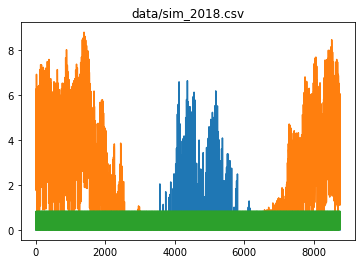

C:\Users\MrX\AppData\Local\Temp/ipykernel_19156/2863304330.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Heating setpoint'][24*134:24*257] = 0
C:\Users\MrX\AppData\Local\Temp/ipykernel_19156/2863304330.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Cooling setpoint'][:24*104] = 0
C:\Users\MrX\AppData\Local\Temp/ipykernel_19156/2863304330.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Cooling s

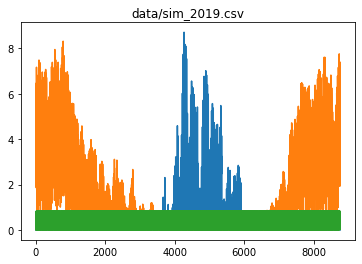

C:\Users\MrX\AppData\Local\Temp/ipykernel_19156/2863304330.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Heating setpoint'][24*134:24*257] = 0
C:\Users\MrX\AppData\Local\Temp/ipykernel_19156/2863304330.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Cooling setpoint'][:24*104] = 0
C:\Users\MrX\AppData\Local\Temp/ipykernel_19156/2863304330.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Cooling s

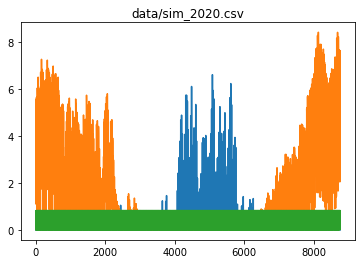

C:\Users\MrX\AppData\Local\Temp/ipykernel_19156/2863304330.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Heating setpoint'][24*134:24*257] = 0
C:\Users\MrX\AppData\Local\Temp/ipykernel_19156/2863304330.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Cooling setpoint'][:24*104] = 0
C:\Users\MrX\AppData\Local\Temp/ipykernel_19156/2863304330.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Cooling s

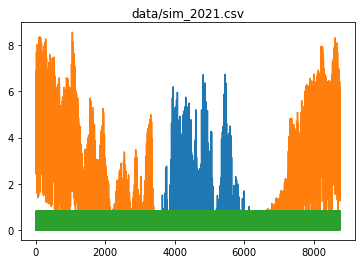

In [23]:
dff_sim_2018 = extract_columns_from_csv('data/sim_2018.csv')
dff_sim_2019=extract_columns_from_csv('data/sim_2019.csv')
dff_sim_2020=extract_columns_from_csv('data/sim_2020.csv')
dff_sim_2021=extract_columns_from_csv('data/sim_2021.csv')

C:\Users\MrX\AppData\Local\Temp/ipykernel_19156/2628734063.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff_sim_2018['Heating setpoint'][24*134:24*257] = 0
C:\Users\MrX\AppData\Local\Temp/ipykernel_19156/2628734063.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff_sim_2018['Cooling setpoint'][:24*104] = 0
C:\Users\MrX\AppData\Local\Temp/ipykernel_19156/2628734063.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff_s

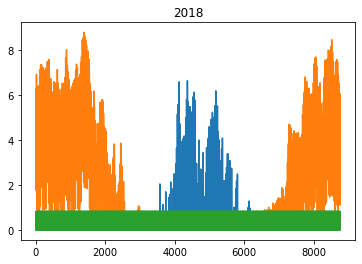

In [9]:
# df_sim_2018 = pd.read_csv('data/sim_2018.csv')
#
# dff_sim_2018 = pd.DataFrame(df_sim_2018, columns=columns)
#
# dff_sim_2018['DistrictCooling:Facility [J](Hourly)'] = dff_sim_2018['DistrictCooling:Facility [J](Hourly)']/3.6e6
# dff_sim_2018['DistrictHeating:Facility [J](Hourly)'] = dff_sim_2018['DistrictHeating:Facility [J](Hourly)']/3.6e6
# dff_sim_2018['InteriorLights:Electricity [J](Hourly)'] = dff_sim_2018['InteriorLights:Electricity [J](Hourly)']/3.6e6
# dff_sim_2018['Temp_IN'] = dff_sim_2018[['ROOF:ZONE1:Zone Operative Temperature [C](Hourly:ON)',
#                                         'MAINXGROUND:ZONE4:Zone Operative Temperature [C](Hourly:ON)',
#                                         'MAINXGROUND:ZONE1:Zone Operative Temperature [C](Hourly:ON)',
#                                         'MAINXGROUND:ZONE5:Zone Operative Temperature [C](Hourly:ON)',
#                                         'MAINXGROUND:ZONE2:Zone Operative Temperature [C](Hourly:ON)',
#                                         'MAINXGROUND:ZONE3:Zone Operative Temperature [C](Hourly:ON)',
#                                         'MAINXOFFICE:ZONE2:Zone Operative Temperature [C](Hourly:ON)',
#                                         'MAINXOFFICE:ZONE1:Zone Operative Temperature [C](Hourly:ON)',
#                                         'MAINXFIRST:ZONE1:Zone Operative Temperature [C](Hourly:ON)',
#                                         'MAINXFIRST:ZONE2:Zone Operative Temperature [C](Hourly:ON)',
#                                         'MAINXFIRST:ZONE3:Zone Operative Temperature [C](Hourly:ON)',
#                                         'MAINXFIRST:ZONE4:Zone Operative Temperature [C](Hourly:ON)']].mean(1)
#
# dff_sim_2018['Heating setpoint'] = 21
# dff_sim_2018['Heating setpoint'][24*134:24*257] = 0
# dff_sim_2018['Cooling setpoint'] = 24
# dff_sim_2018['Cooling setpoint'][:24*104] = 0
# dff_sim_2018['Cooling setpoint'][24*287:] = 0
# dff_sim_2018.head()
# plt.figure()
# plt.title('2018')
# dff_sim_2018['DistrictCooling:Facility [J](Hourly)'].plot()
# dff_sim_2018['DistrictHeating:Facility [J](Hourly)'].plot()
# dff_sim_2018['InteriorLights:Electricity [J](Hourly)'].plot()
# plt.show()

C:\Users\MrX\AppData\Local\Temp/ipykernel_19156/2933710197.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff_sim_2019['Heating setpoint'][24*134:24*257] = 0
C:\Users\MrX\AppData\Local\Temp/ipykernel_19156/2933710197.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff_sim_2019['Cooling setpoint'][:24*104] = 0
C:\Users\MrX\AppData\Local\Temp/ipykernel_19156/2933710197.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff_s

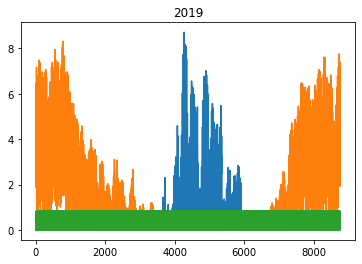

In [4]:
# df_sim_2019 = pd.read_csv('data/sim_2019.csv')
#
#
# dff_sim_2019 = pd.DataFrame(df_sim_2019, columns=columns)
#
# dff_sim_2019['DistrictCooling:Facility [J](Hourly)'] = dff_sim_2019['DistrictCooling:Facility [J](Hourly)']/3.6e6
# dff_sim_2019['DistrictHeating:Facility [J](Hourly)'] = dff_sim_2019['DistrictHeating:Facility [J](Hourly)']/3.6e6
# dff_sim_2019['InteriorLights:Electricity [J](Hourly)'] = dff_sim_2019['InteriorLights:Electricity [J](Hourly)']/3.6e6
# dff_sim_2019['Temp_IN'] = dff_sim_2019[['ROOF:ZONE1:Zone Operative Temperature [C](Hourly:ON)',
#                                         'MAINXGROUND:ZONE4:Zone Operative Temperature [C](Hourly:ON)',
#                                         'MAINXGROUND:ZONE1:Zone Operative Temperature [C](Hourly:ON)',
#                                         'MAINXGROUND:ZONE5:Zone Operative Temperature [C](Hourly:ON)',
#                                         'MAINXGROUND:ZONE2:Zone Operative Temperature [C](Hourly:ON)',
#                                         'MAINXGROUND:ZONE3:Zone Operative Temperature [C](Hourly:ON)',
#                                         'MAINXOFFICE:ZONE2:Zone Operative Temperature [C](Hourly:ON)',
#                                         'MAINXOFFICE:ZONE1:Zone Operative Temperature [C](Hourly:ON)',
#                                         'MAINXFIRST:ZONE1:Zone Operative Temperature [C](Hourly:ON)',
#                                         'MAINXFIRST:ZONE2:Zone Operative Temperature [C](Hourly:ON)',
#                                         'MAINXFIRST:ZONE3:Zone Operative Temperature [C](Hourly:ON)',
#                                         'MAINXFIRST:ZONE4:Zone Operative Temperature [C](Hourly:ON)']].mean(1)
#
# dff_sim_2019['Heating setpoint'] = 21
# dff_sim_2019['Heating setpoint'][24*134:24*257] = 0
# dff_sim_2019['Cooling setpoint'] = 24
# dff_sim_2019['Cooling setpoint'][:24*104] = 0
# dff_sim_2019['Cooling setpoint'][24*287:] = 0
# dff_sim_2019.head()
# plt.figure()
# plt.title('2019')
# dff_sim_2019['DistrictCooling:Facility [J](Hourly)'].plot()
# dff_sim_2019['DistrictHeating:Facility [J](Hourly)'].plot()
# dff_sim_2019['InteriorLights:Electricity [J](Hourly)'].plot()
# plt.show()

C:\Users\MrX\AppData\Local\Temp/ipykernel_19156/1546044383.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff_sim_2020['Heating setpoint'][24*134:24*257] = 0
C:\Users\MrX\AppData\Local\Temp/ipykernel_19156/1546044383.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff_sim_2020['Cooling setpoint'][:24*104] = 0
C:\Users\MrX\AppData\Local\Temp/ipykernel_19156/1546044383.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff_s

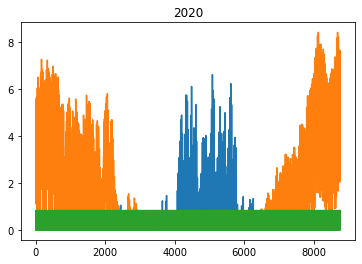

In [5]:
# df_sim_2020 = pd.read_csv('data/sim_2020.csv')
#
#
# dff_sim_2020 = pd.DataFrame(df_sim_2020, columns=columns)
#
# dff_sim_2020['DistrictCooling:Facility [J](Hourly)'] = dff_sim_2020['DistrictCooling:Facility [J](Hourly)']/3.6e6
# dff_sim_2020['DistrictHeating:Facility [J](Hourly)'] = dff_sim_2020['DistrictHeating:Facility [J](Hourly)']/3.6e6
# dff_sim_2020['InteriorLights:Electricity [J](Hourly)'] = dff_sim_2020['InteriorLights:Electricity [J](Hourly)']/3.6e6
# dff_sim_2020['Temp_IN'] = dff_sim_2020[['ROOF:ZONE1:Zone Operative Temperature [C](Hourly:ON)',
#                                         'MAINXGROUND:ZONE4:Zone Operative Temperature [C](Hourly:ON)',
#                                         'MAINXGROUND:ZONE1:Zone Operative Temperature [C](Hourly:ON)',
#                                         'MAINXGROUND:ZONE5:Zone Operative Temperature [C](Hourly:ON)',
#                                         'MAINXGROUND:ZONE2:Zone Operative Temperature [C](Hourly:ON)',
#                                         'MAINXGROUND:ZONE3:Zone Operative Temperature [C](Hourly:ON)',
#                                         'MAINXOFFICE:ZONE2:Zone Operative Temperature [C](Hourly:ON)',
#                                         'MAINXOFFICE:ZONE1:Zone Operative Temperature [C](Hourly:ON)',
#                                         'MAINXFIRST:ZONE1:Zone Operative Temperature [C](Hourly:ON)',
#                                         'MAINXFIRST:ZONE2:Zone Operative Temperature [C](Hourly:ON)',
#                                         'MAINXFIRST:ZONE3:Zone Operative Temperature [C](Hourly:ON)',
#                                         'MAINXFIRST:ZONE4:Zone Operative Temperature [C](Hourly:ON)']].mean(1)
#
# dff_sim_2020['Heating setpoint'] = 21
# dff_sim_2020['Heating setpoint'][24*134:24*257] = 0
# dff_sim_2020['Cooling setpoint'] = 24
# dff_sim_2020['Cooling setpoint'][:24*104] = 0
# dff_sim_2020['Cooling setpoint'][24*287:] = 0
# dff_sim_2020.head()
# plt.figure()
# plt.title('2020')
# dff_sim_2020['DistrictCooling:Facility [J](Hourly)'].plot()
# dff_sim_2020['DistrictHeating:Facility [J](Hourly)'].plot()
# dff_sim_2020['InteriorLights:Electricity [J](Hourly)'].plot()
# plt.show()

C:\Users\MrX\AppData\Local\Temp/ipykernel_19156/2835838454.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff_sim_2021['Heating setpoint'][24*134:24*257] = 0
C:\Users\MrX\AppData\Local\Temp/ipykernel_19156/2835838454.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff_sim_2021['Cooling setpoint'][:24*104] = 0
C:\Users\MrX\AppData\Local\Temp/ipykernel_19156/2835838454.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff_s

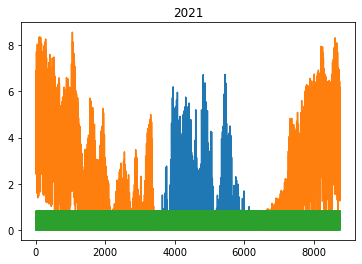

In [6]:
# df_sim_2021 = pd.read_csv('data/sim_2021.csv')
#
#
# dff_sim_2021 = pd.DataFrame(df_sim_2021, columns=columns)
#
# dff_sim_2021['DistrictCooling:Facility [J](Hourly)'] = dff_sim_2021['DistrictCooling:Facility [J](Hourly)']/3.6e6
# dff_sim_2021['DistrictHeating:Facility [J](Hourly)'] = dff_sim_2021['DistrictHeating:Facility [J](Hourly)']/3.6e6
# dff_sim_2021['InteriorLights:Electricity [J](Hourly)'] = dff_sim_2021['InteriorLights:Electricity [J](Hourly)']/3.6e6
# dff_sim_2021['Temp_IN'] = dff_sim_2021[['ROOF:ZONE1:Zone Operative Temperature [C](Hourly:ON)',
#                                         'MAINXGROUND:ZONE4:Zone Operative Temperature [C](Hourly:ON)',
#                                         'MAINXGROUND:ZONE1:Zone Operative Temperature [C](Hourly:ON)',
#                                         'MAINXGROUND:ZONE5:Zone Operative Temperature [C](Hourly:ON)',
#                                         'MAINXGROUND:ZONE2:Zone Operative Temperature [C](Hourly:ON)',
#                                         'MAINXGROUND:ZONE3:Zone Operative Temperature [C](Hourly:ON)',
#                                         'MAINXOFFICE:ZONE2:Zone Operative Temperature [C](Hourly:ON)',
#                                         'MAINXOFFICE:ZONE1:Zone Operative Temperature [C](Hourly:ON)',
#                                         'MAINXFIRST:ZONE1:Zone Operative Temperature [C](Hourly:ON)',
#                                         'MAINXFIRST:ZONE2:Zone Operative Temperature [C](Hourly:ON)',
#                                         'MAINXFIRST:ZONE3:Zone Operative Temperature [C](Hourly:ON)',
#                                         'MAINXFIRST:ZONE4:Zone Operative Temperature [C](Hourly:ON)']].mean(1)
#
# dff_sim_2021['Heating setpoint'] = 21
# dff_sim_2021['Heating setpoint'][24*134:24*257] = 0
# dff_sim_2021['Cooling setpoint'] = 24
# dff_sim_2021['Cooling setpoint'][:24*104] = 0
# dff_sim_2021['Cooling setpoint'][24*287:] = 0
# dff_sim_2021.head()
# plt.figure()
# plt.title('2021')
# dff_sim_2021['DistrictCooling:Facility [J](Hourly)'].plot()
# dff_sim_2021['DistrictHeating:Facility [J](Hourly)'].plot()
# dff_sim_2021['InteriorLights:Electricity [J](Hourly)'].plot()
# plt.show()

In [70]:
dff_sim_2021.head()

,Date/Time,DistrictCooling:Facility [J](Hourly),DistrictHeating:Facility [J](Hourly),InteriorLights:Electricity [J](Hourly),ROOF:ZONE1:Zone Operative Temperature [C](Hourly:ON),MAINXGROUND:ZONE4:Zone Operative Temperature [C](Hourly:ON),MAINXGROUND:ZONE1:Zone Operative Temperature [C](Hourly:ON),MAINXGROUND:ZONE5:Zone Operative Temperature [C](Hourly:ON),MAINXGROUND:ZONE2:Zone Operative Temperature [C](Hourly:ON),MAINXGROUND:ZONE3:Zone Operative Temperature [C](Hourly:ON),...,Environment:Site Outdoor Air Barometric Pressure [Pa](Hourly),Environment:Site Wind Speed [m/s](Hourly),Environment:Site Wind Direction [deg](Hourly),Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](Hourly),Environment:Site Direct Solar Radiation Rate per Area [W/m2](Hourly),Environment:Site Solar Azimuth Angle [deg](Hourly),Environment:Site Solar Altitude Angle [deg](Hourly),Temp_IN,Heating setpoint,Cooling setpoint
0,01/01 01:00:00,0.0,4.046451,0.0,-0.052513,17.323153,14.947875,16.271978,16.131086,18.560286,...,95112.083333,0.162979,310.93750,0.0,0.0,9.218535,-67.993246,15.638372,21,0
1,01/01 02:00:00,0.0,4.114607,0.0,-0.126156,16.901947,14.856165,16.221401,16.063818,18.577422,...,95145.000000,0.411948,310.46875,0.0,0.0,34.159499,-64.819077,15.537999,21,0
2,01/01 03:00:00,0.0,4.150748,0.0,-0.082672,16.763148,14.796894,16.184600,16.019684,18.589922,...,95145.000000,0.215442,304.68750,0.0,0.0,58.222105,-57.144973,15.501836,21,0
3,01/01 04:00:00,0.0,4.200853,0.0,-0.142427,16.652175,14.751163,16.153465,15.985033,18.599881,...,95145.000000,0.003104,296.71875,0.0,0.0,74.474857,-47.428622,15.465096,21,0
4,01/01 05:00:00,0.0,4.262618,0.0,-0.276789,16.553050,14.712447,16.125484,15.955007,18.608131,...,95145.000000,0.004346,261.56250,0.0,0.0,86.722817,-36.964427,15.425890,21,0


In [71]:
ts = []
for elem in dff_sim_2018['Date/Time']:
    temp = elem
    splitted = temp.split(' ')
    date = splitted[1]
    time = splitted[3]
    if (time == '24:00:00'):
        time = '00:00:00'
    timestamp = datetime.strptime(f'{date}/2018 {time}', '%m/%d/%Y %H:%M:%S')
    if (time == '00:00:00'):
        timestamp += timedelta(days=1)
    ts.append(timestamp)

dff_sim_2018['Date/Time'] = pd.to_datetime(ts, format='%m/%d/%Y %H:%M:%S')

ts = []
for elem in dff_sim_2019['Date/Time']:
    temp = elem
    splitted = temp.split(' ')
    try:
        date = splitted[1]
        time = splitted[3]
    except Exception as e:
        date = splitted[0]
        time = splitted[2]
    if (time == '24:00:00'):
        time = '00:00:00'
    timestamp = datetime.strptime(f'{date}/2019 {time}', '%m/%d/%Y %H:%M:%S')
    if (time == '00:00:00'):
        timestamp += timedelta(days=1)
    ts.append(timestamp)
dff_sim_2019['Date/Time'] = pd.to_datetime(ts, format='%m/%d/%Y %H:%M:%S')

ts = []
for elem in dff_sim_2020['Date/Time']:
    temp = elem
    splitted = temp.split(' ')
    date = splitted[1]
    time = splitted[3]

    if (time == '24:00:00'):
        time = '00:00:00'
    timestamp = datetime.strptime(f'{date}/2020 {time}', '%m/%d/%Y %H:%M:%S')
    if (time == '00:00:00'):
        timestamp += timedelta(days=1)
    ts.append(timestamp)
dff_sim_2020['Date/Time'] = pd.to_datetime(ts, format='%m/%d/%Y %H:%M:%S')

ts = []
for elem in dff_sim_2021['Date/Time']:
    temp = elem
    splitted = temp.split(' ')
    date = splitted[1]
    time = splitted[3]
    if (time == '24:00:00'):
        time = '00:00:00'
    timestamp = datetime.strptime(f'{date}/2021 {time}', '%m/%d/%Y %H:%M:%S')
    if (time == '00:00:00'):
        timestamp += timedelta(days=1)
    ts.append(timestamp)
dff_sim_2021['Date/Time'] = pd.to_datetime(ts, format='%m/%d/%Y %H:%M:%S')

In [72]:
df_train = pd.concat([dff_sim_2018, dff_sim_2019, dff_sim_2020], axis=0)
df_train.reset_index(drop=True, inplace=True)
df_test = dff_sim_2021

In [73]:
regressands = [
      'Temp_IN'
]
features = [
    # 'Environment:Site Outdoor Air Drybulb Temperature [C](Hourly)',
    # 'Environment:Site Outdoor Air Dewpoint Temperature [C](Hourly)',
    # 'Environment:Site Outdoor Air Barometric Pressure [Pa](Hourly)',
    # 'Environment:Site Wind Speed [m/s](Hourly)',
    # 'Environment:Site Wind Direction [deg](Hourly)',
    # 'Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](Hourly)',
    # 'Environment:Site Direct Solar Radiation Rate per Area [W/m2](Hourly)',
    # 'Environment:Site Solar Azimuth Angle [deg](Hourly)',
    # 'Environment:Site Solar Altitude Angle [deg](Hourly)',
    'Temp_IN',  # comment out if predicting Temp_IN
    # 'Heating setpoint',  # comment out unnecessary features depending on the regressand
    # 'Cooling setpoint'
]

SINGLE RUN OF THE MODEL

In [74]:
days = []
months = []
years = []
hours = []
minutes = []
for timestamp in df_train['Date/Time']:
    days.append(timestamp.day)
    months.append(timestamp.month)
    years.append(timestamp.year)
    hours.append(timestamp.hour)
    minutes.append(timestamp.minute)

X_train = pd.DataFrame()
X_train['day'] = days
X_train['month'] = months
X_train['year'] = years
X_train['hour'] = hours
X_train['minute'] = minutes
X_train.index = df_train.index

X_train = X_train.join(df_train[np.concatenate((features, regressands))])
X_train.describe()

,day,month,year,hour,minute,Temp_IN,Temp_IN
count,26280.000000,26280.000000,26280.000000,26280.000000,26280.0,26280.000000,26280.000000
mean,15.721613,6.525989,2019.000114,11.500000,0.0,20.778189,20.778189
std,8.796327,3.447961,0.816582,6.922318,0.0,4.260116,4.260116
min,1.000000,1.000000,2018.000000,0.000000,0.0,14.412769,14.412769
25%,8.000000,4.000000,2018.000000,5.750000,0.0,16.921788,16.921788
50%,16.000000,7.000000,2019.000000,11.500000,0.0,19.513736,19.513736
75%,23.000000,10.000000,2020.000000,17.250000,0.0,24.756853,24.756853
max,31.000000,12.000000,2021.000000,23.000000,0.0,31.387367,31.387367


In [75]:
X_train = X_train.astype('float32')
normalized_X_train=(X_train-X_train.min())/(X_train.max()-X_train.min())
normalized_X_train.dropna(axis=1, inplace=True)
y_train_min, y_train_max = X_train[regressands].min(), X_train[regressands].max()
y_train_mean, y_train_std = X_train[regressands].mean(), X_train[regressands].std()


In [76]:
window = 6  # number of past values used to predict the next ones, in this case one hour (1)
forseen = 1  # number of future sample to predict, in this case one hour (1)

In [77]:
trainX, trainY = [], []
for j in range(window, len(normalized_X_train.index)-forseen, 1):
    input, val = normalized_X_train.values[j-window:j, :], normalized_X_train.values[j:j+forseen,-len(regressands):]  # I know that regressand is in the last column
    trainX.append(input)
    trainY.append(val)

In [78]:
#val_size = round(len(trainX)*0.25)
val_size = 24*60  # 2 months
valX = []
valY = []
for v in range(val_size):
    rand_i = random.choice(range(len(trainX)))
    valX.append(trainX.pop(rand_i))
    valY.append(trainY.pop(rand_i))

trainX = np.array(trainX)
trainY = np.array(trainY)
valX = np.array(valX)
valY = np.array(valY)
print('trainX shape ', trainX.shape)
print('trainY shape ', trainY.shape)
print('valX shape ', valX.shape)
print('valY shape ', valY.shape)

trainX shape  (24833, 6, 6)
trainY shape  (24833, 1, 1)
valX shape  (1440, 6, 6)
valY shape  (1440, 1, 1)


In [79]:
days = []
months = []
years = []
hours = []
minutes = []
for timestamp in df_test['Date/Time']:
    days.append(timestamp.day)
    months.append(timestamp.month)
    years.append(timestamp.year)
    hours.append(timestamp.hour)
    minutes.append(timestamp.minute)

X_test = pd.DataFrame()
X_test['day'] = days
X_test['month'] = months
X_test['year'] = years
X_test['hour'] = hours
X_test['minute'] = minutes
X_test.describe()
X_test.index = df_test.index
X_test = X_test.join(df_test[np.concatenate((features, regressands))])

X_test = X_test.astype('float32')
normalized_X_test=(X_test-X_train.min())/(X_train.max()-X_train.min())
#normalized_X_test=(X_test-X_test.min())/(X_test.max()-X_test.min())

normalized_X_test.dropna(axis=1, inplace=True)
#y_test_min, y_test_max = X_test[regressands].min(), X_test[regressands].max()

testX = []
for t in range(window, len(normalized_X_test.index)-forseen, forseen):
    testX.append(normalized_X_test.values[t-window:t, :])
testX = np.array(testX)

Keras model

In [80]:
# Model
model_choice = 'cnn_lstm'  # 'single_lstm', 'stacked_lstm', 'lstm_cnn'

if model_choice == 'single_lstm':
    model = Sequential()
    model.add(InputLayer(input_shape=(window, normalized_X_train.shape[1])))
    model.add(LSTM(64))
    model.add(Dense(forseen*len(regressands)))
    model.add(ReLU())
    model.add(Reshape((forseen, len(regressands))))

if model_choice == 'stacked_lstm':
    model = Sequential()
    model.add(InputLayer(input_shape=(window, normalized_X_train.shape[1])))
    model.add(LSTM(64, return_sequences=True))  #
    model.add(LSTM(32)) # add return_sequences=True, in the previous layer
    model.add(Dense(forseen*len(regressands)))
    model.add(ReLU())
    model.add(Reshape((forseen, len(regressands))))

if model_choice == 'cnn_lstm':
    model = Sequential()
    model.add(Reshape((window, normalized_X_train.shape[1], 1), input_shape=(window, normalized_X_train.shape[1])))
    model.add(Conv2D(filters=64, kernel_size=(2,1), strides=1, padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,1), strides=(1,1)))
    model.add(Conv2D(filters=64, kernel_size=(2,1), strides=1, padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,1), strides=(1,1)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(64, activation='tanh'))
    model.add(Dense(32))
    model.add(Dense(forseen*len(regressands)))
    model.add(ReLU())
    model.add(Reshape((forseen, len(regressands))))


model.compile(loss='mse', optimizer='adam', metrics='mean_absolute_error')
print(model.summary())

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_26 (Reshape)        (None, 6, 6, 1)           0         
                                                                 
 conv2d_26 (Conv2D)          (None, 5, 6, 64)          192       
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 4, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 3, 6, 64)          8256      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 2, 6, 64)         0         
 g2D)                                                            
                                                                 
 time_distributed_13 (TimeDi  (None, 2, 384)         

In [81]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=3)
mc = ModelCheckpoint(f'{regressands[0].split(":")[0]}/{model_choice}.h5', monitor='val_loss', mode='min', save_weights_only=True, save_best_only=True)

Training phase

In [51]:
try:
    model.load_weights(f'{regressands[0].split(":")[0]}/{model_choice}.h5')
    print('Already trained model found!')
except:
    history = model.fit(x=trainX, y=trainY, batch_size=10, epochs=30, shuffle=True, validation_data=(valX, valY), callbacks=[es, mc])

# history = model.fit(x=trainX, y=trainY, batch_size=10, epochs=5, shuffle=True, validation_data=(valX, valY), callbacks=[es, mc])

Epoch 1/30
2484/2484 [==============================] - 21s 8ms/step - loss: 1.9669e-04 - mean_absolute_error: 0.0106 - val_loss: 1.3504e-04 - val_mean_absolute_error: 0.0087
Epoch 2/30
2484/2484 [==============================] - 19s 8ms/step - loss: 1.8524e-04 - mean_absolute_error: 0.0103 - val_loss: 1.7555e-04 - val_mean_absolute_error: 0.0107
Epoch 3/30
2484/2484 [==============================] - 20s 8ms/step - loss: 1.8144e-04 - mean_absolute_error: 0.0101 - val_loss: 1.2830e-04 - val_mean_absolute_error: 0.0086
Epoch 4/30
2484/2484 [==============================] - 21s 8ms/step - loss: 1.7367e-04 - mean_absolute_error: 0.0099 - val_loss: 1.1898e-04 - val_mean_absolute_error: 0.0083
Epoch 5/30
2484/2484 [==============================] - 22s 9ms/step - loss: 1.6466e-04 - mean_absolute_error: 0.0096 - val_loss: 1.1587e-04 - val_mean_absolute_error: 0.0081
Epoch 6/30
2484/2484 [==============================] - 21s 9ms/step - loss: 1.6155e-04 - mean_absolute_error: 0.0095 - val_l

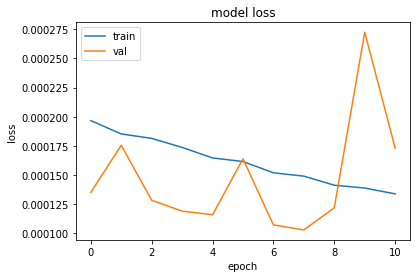

In [52]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Test phase

274/274 [==============================] - 1s 3ms/step
MAE (Temp_IN):  0.6873
RMSE (Temp_IN):  0.8845


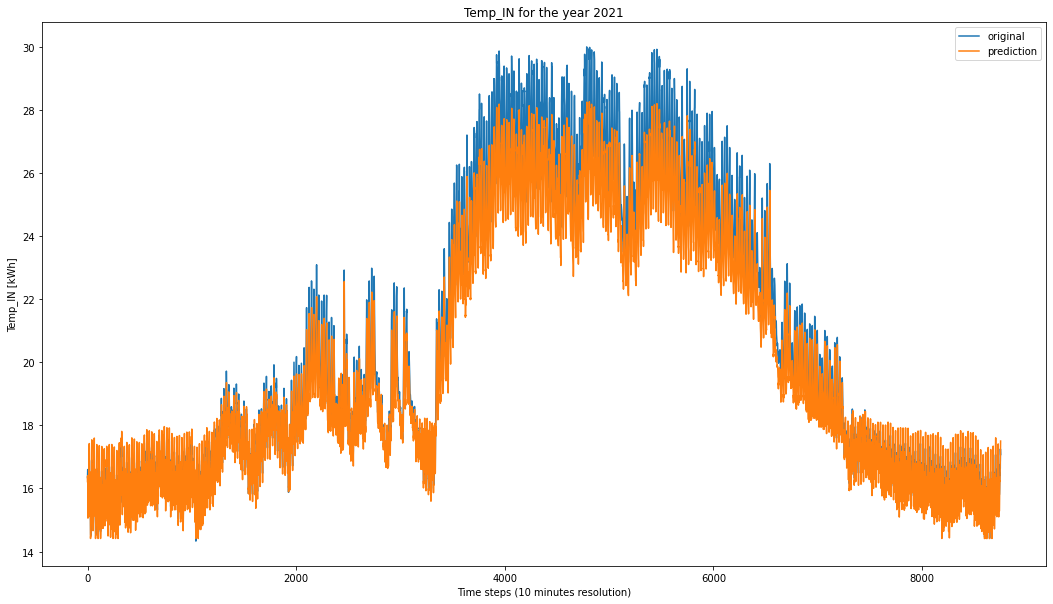

In [53]:
model.load_weights(f'{regressands[0].split(":")[0]}/{model_choice}.h5')
final_pred = {}

out = model.predict(testX)

for i, reg in enumerate(regressands):
    temp = out[:, :, i] * (y_train_max[i] - y_train_min[i]) + y_train_min[i]
    # temp = out[:, :, i] * y_train_std[i]
    final_pred[reg] = temp.reshape((testX.shape[0]*forseen))
    err = (abs(X_test.values[window:window+len(final_pred[reg]), -len(regressands)+i]-final_pred[reg])).mean()
    rmse = math.sqrt(((X_test.values[window:window+len(final_pred[reg]), -len(regressands)+i]-final_pred[reg])**2).mean())
    print(f'MAE ({regressands[0].split(":")[0]}): ', round(err, 4))
    print(f'RMSE ({regressands[0].split(":")[0]}): ', round(rmse, 4))

    fig = plt.figure(figsize=(18,10))
    plt.title(reg)
    plt.plot(X_test.values[window:window+len(final_pred[reg]), 5+len(features)+i], label='original')
    plt.plot(final_pred[reg], label=f'prediction')
    plt.ylabel(f'{regressands[0].split(":")[0]} [kWh]')
    plt.xlabel('Time steps (10 minutes resolution)')
    plt.title(f'{regressands[0].split(":")[0]} for the year 2021')
    plt.legend()
    plt.show()

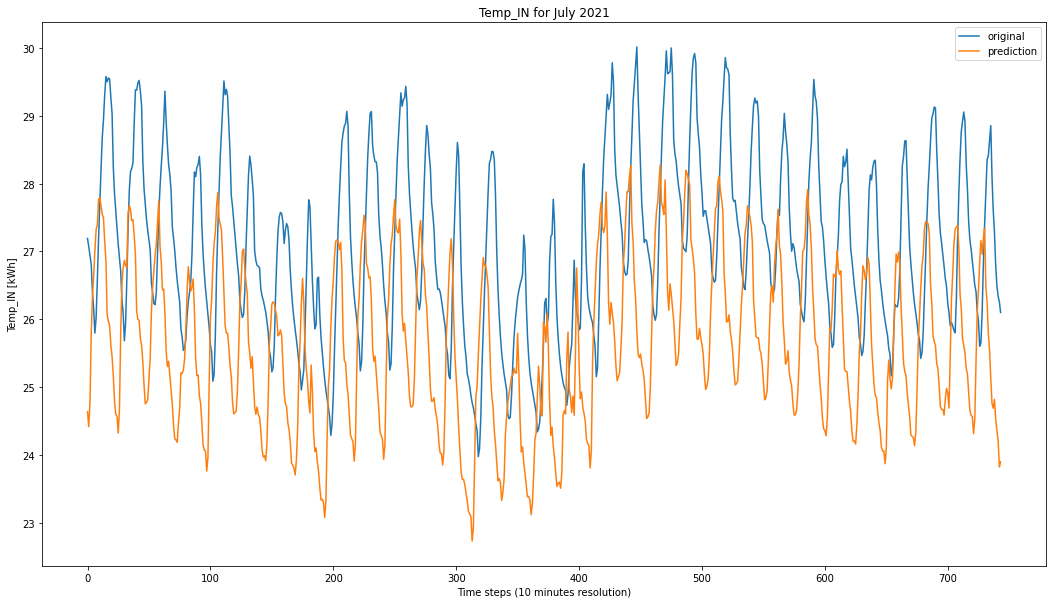

In [54]:
for i, reg in enumerate(regressands):
    fig = plt.figure(figsize=(18,10))
    plt.title(reg)
    plt.plot(X_test.values[24*181:24*212, 5+len(features)+i], label='original')
    plt.plot(final_pred[reg][24*181:24*212], label=f'prediction')
    plt.ylabel(f'{regressands[0].split(":")[0]} [kWh]')
    plt.xlabel('Time steps (10 minutes resolution)')
    plt.title(f'{regressands[0].split(":")[0]} for July 2021')
    plt.legend()
    plt.show()

(EXTRA) FORECASTING WINDOW OPTIMIZATION

In [82]:
# Loading the dataset and splitting it into train and test subsets
days = []
months = []
hours = []
years = []
minutes = []
for timestamp in df_train['Date/Time']:
    days.append(timestamp.day)
    months.append(timestamp.month)
    hours.append(timestamp.hour)
    years.append(timestamp.year)
    minutes.append(timestamp.minute)

X_train = pd.DataFrame()
X_train['day'] = days
X_train['month'] = months
X_train['year'] = years
X_train['hour'] = hours
X_train['minute'] = minutes

X_train.index = df_train.index
X_train = X_train.join(df_train[np.concatenate((features, regressands))])

X_train = X_train.astype('float32')
normalized_X_train=(X_train-X_train.min())/(X_train.max()-X_train.min())
normalized_X_train.dropna(axis=1, inplace=True)
y_train_min, y_train_max = X_train[regressands].min(), X_train[regressands].max()
y_train_mean, y_train_std = X_train[regressands].mean(), X_train[regressands].std()

# Loading the test dataset
days = []
months = []
years = []
hours = []
minutes = []
for timestamp in df_test['Date/Time']:
    days.append(timestamp.day)
    months.append(timestamp.month)
    years.append(timestamp.year)
    hours.append(timestamp.hour)
    minutes.append(timestamp.minute)

X_test = pd.DataFrame()
X_test['day'] = days
X_test['month'] = months
X_test['year'] = years
X_test['hour'] = hours
X_test['minute'] = minutes
X_test.index = df_test.index
X_test = X_test.join(df_test[np.concatenate((features, regressands))])

X_test = X_test.astype('float32')
normalized_X_test=(X_test-X_train.min())/(X_train.max()-X_train.min())
normalized_X_test.dropna(axis=1, inplace=True)
#normalized_X_test=(X_test-X_test.min())/(X_test.max()-X_test.min())
y_test_min, y_test_max = X_test[regressands].min(), X_test[regressands].max()

In [86]:
sizes = np.array([6, 12, 24, 48, 72, 96, 120, 144, 168])
mae_values = {}
#pred_values = {}
#real_values = {}
rmse_values = {}
for i in sizes:
    window = i
    forseen = 1
    print(f'window: {window}')
    print(f'forseen: {forseen}')
    trainX, trainY = [], []
    for j in range(window, len(normalized_X_train.index)-forseen, 1):
        input, val = normalized_X_train.values[j-window:j, :], normalized_X_train.values[j:j+forseen,-len(regressands):]  # I know that regressands are the last columns
        trainX.append(input)
        trainY.append(val)

    #val_size = round(len(trainX)*0.25)
    val_size = 24*60  # 2 months
    valX = []
    valY = []
    for v in range(val_size):
        rand_i = random.choice(range(len(trainX)))
        valX.append(trainX.pop(rand_i))
        valY.append(trainY.pop(rand_i))

    trainX = np.array(trainX)
    trainY = np.array(trainY)
    valX = np.array(valX)
    valY = np.array(valY)
    print(f'trainX shape: {trainX.shape}')
    print(f'trainY shape: {trainY.shape}')
    print(f'valX shape: {valX.shape}')
    print(f'valY shape: {valY.shape}')

    testX = []
    for t in range(window, len(normalized_X_test.index)-forseen, forseen):
        testX.append(normalized_X_test.values[t-window:t, :])
    testX = np.array(testX)
    print(f'testX shape: {testX.shape}')
    print("")
    # Model
    model = Sequential()
    model.add(Reshape((window, normalized_X_train.shape[1], 1), input_shape=(window, normalized_X_train.shape[1])))
    model.add(Conv2D(filters=64, kernel_size=(2,1), strides=1, padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,1), strides=(1,1)))
    model.add(Conv2D(filters=64, kernel_size=(2,1), strides=1, padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,1), strides=(1,1)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(64, activation='tanh'))
    model.add(Dense(32))
    model.add(Dense(forseen*len(regressands)))
    model.add(ReLU())
    model.add(Reshape((forseen, len(regressands))))
    #
    #lr_schedule = ExponentialDecay(initial_learning_rate=0.2, decay_steps=1000, decay_rate=0.9, staircase=False)  # 0.0053 17/30
    #opt = Adagrad(learning_rate=lr_schedule)
    model.compile(loss='mse', optimizer='adam', metrics='mean_absolute_error')
    # print(model.summary())

    es = EarlyStopping(monitor='val_loss', mode='min', patience=3)
    mc = ModelCheckpoint(f'{regressands[0].split(":")[0]}/{i}H_forecast.h5', monitor='val_loss', mode='min', save_weights_only=True, save_best_only=True)

    print(f'Forecasting {i}H ahead...')
    try:
        model.load_weights(f'{regressands[0].split(":")[0]}/{i}H_forecast.h5')
        print('Already trained model found!')
    except:
        history = model.fit(x=trainX, y=trainY, batch_size=10, epochs=30, shuffle=True, validation_data=(valX, valY), callbacks=[es, mc])
    print('\n-------------------------- ----\n')

    model.load_weights(f'{regressands[0].split(":")[0]}/{i}H_forecast.h5')

    final_pred = model.predict(testX)[:,:,0]*(y_train_max.iloc[0]-y_train_min.iloc[0])+y_train_min.iloc[0]

    final_pred = final_pred.reshape((testX.shape[0]*forseen))

    mae = (abs(X_test.values[window:window+len(final_pred), -1]-final_pred)).mean()
    rmse = math.sqrt(((X_test.values[window:window+len(final_pred), -1]-final_pred)**2).mean())

    mae_values[f'{i}H'] = [mae]
    rmse_values[f'{i}H'] = [rmse]
    #pred_values[f'{i//6}H'] = final_pred[:(len(X_test)-window)]
    #real_values[f'{i//6}H'] = X_test.values[window:, -1]

window: 6
forseen: 1
trainX shape: (24833, 6, 6)
trainY shape: (24833, 1, 1)
valX shape: (1440, 6, 6)
valY shape: (1440, 1, 1)
testX shape: (8753, 6, 6)

Forecasting 6H ahead...
Epoch 1/30
2484/2484 [==============================] - 20s 7ms/step - loss: 0.0015 - mean_absolute_error: 0.0242 - val_loss: 3.6336e-04 - val_mean_absolute_error: 0.0152
Epoch 2/30
2484/2484 [==============================] - 18s 7ms/step - loss: 4.1076e-04 - mean_absolute_error: 0.0155 - val_loss: 4.1830e-04 - val_mean_absolute_error: 0.0166
Epoch 3/30
2484/2484 [==============================] - 18s 7ms/step - loss: 3.4479e-04 - mean_absolute_error: 0.0142 - val_loss: 3.6936e-04 - val_mean_absolute_error: 0.0152
Epoch 4/30
2484/2484 [==============================] - 22s 9ms/step - loss: 3.0142e-04 - mean_absolute_error: 0.0132 - val_loss: 2.8030e-04 - val_mean_absolute_error: 0.0128
Epoch 5/30
2484/2484 [==============================] - 20s 8ms/step - loss: 2.6870e-04 - mean_absolute_error: 0.0125 - val_lo

Plots

In [87]:
pred_x = [x for x in sizes]
pred_y_rmse = []
pred_y_mae = []
print( mae_values.keys())
for k in mae_values.keys():
    print(f'k {k} mae_values.keys {mae_values.keys}')
    pred_y_rmse.append(rmse_values[k][0])
    pred_y_mae.append(mae_values[k][0])

errors_df = pd.DataFrame({'Window [hours]': pred_x, 'MAE': pred_y_mae, 'RMSE': pred_y_rmse})
errors_df.to_csv(f'{regressands[0].split(":")[0]}/errors.csv', index=False)

dict_keys(['6H', '12H', '24H', '48H', '72H', '96H', '120H', '144H', '168H'])
k 6H mae_values.keys <built-in method keys of dict object at 0x0000028A9D9F7E80>
k 12H mae_values.keys <built-in method keys of dict object at 0x0000028A9D9F7E80>
k 24H mae_values.keys <built-in method keys of dict object at 0x0000028A9D9F7E80>
k 48H mae_values.keys <built-in method keys of dict object at 0x0000028A9D9F7E80>
k 72H mae_values.keys <built-in method keys of dict object at 0x0000028A9D9F7E80>
k 96H mae_values.keys <built-in method keys of dict object at 0x0000028A9D9F7E80>
k 120H mae_values.keys <built-in method keys of dict object at 0x0000028A9D9F7E80>
k 144H mae_values.keys <built-in method keys of dict object at 0x0000028A9D9F7E80>
k 168H mae_values.keys <built-in method keys of dict object at 0x0000028A9D9F7E80>


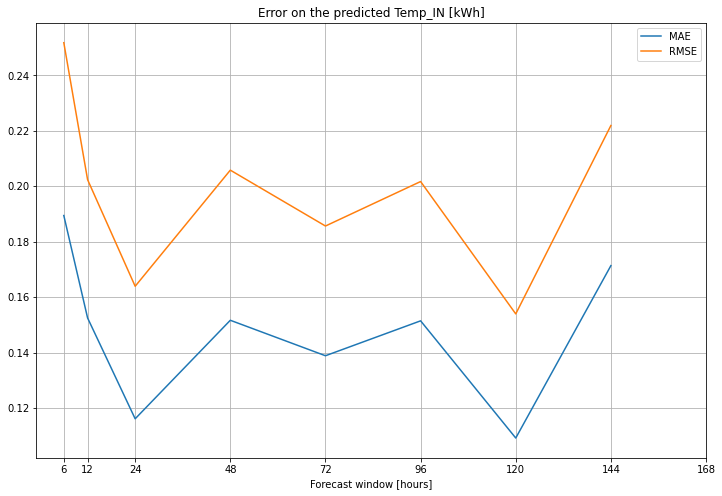

In [90]:
plt.figure(figsize=(12,8))
plt.plot(pred_x[0:-1], pred_y_mae[0:-1], label='MAE')
plt.plot(pred_x[0:-1], pred_y_rmse[0:-1], label='RMSE')
plt.xlabel('Forecast window [hours]')
plt.title(f'Error on the predicted {regressands[0].split(":")[0]} [kWh]')
plt.xticks(pred_x)
plt.grid()
plt.savefig(f'{regressands[0].split(":")[0]}/errors_plot')
plt.legend()